# Bayesian Machine Learning project

In [115]:
import torch 
from torch.distributions.chi2 import Chi2
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [116]:
class GaussianMixtureModel() :
    def __init__(self, sigma=1.) :
        self.sigma = sigma
        self.centers = torch.Tensor([[8*i, 8*j] for i in [-2, -1, 0, 1, 2] for j in [-2, -1, 0, 1, 2]])
        chi2 = Chi2(torch.ones(25))
        omegas = chi2.sample()
        self.weights = omegas/torch.sum(omegas)

    def sample(self, n_sample=1000):
        indices = torch.multinomial(self.weights, num_samples=n_sample, replacement=True)
        sample = self.centers[indices] + torch.randn(n_sample, 2)*self.sigma
        return sample
    
    def measure(self, n_sample) :
        """
        inpainting measure
        """
        x = self.sample(n_sample)
        y = x[:,0] #+ torch.randn(n_sample)*noise
        return y
        
    def posterior_sampling(self, y):
        """
        y is a measure of the first component of x
        """
        n = len(y)
        x = torch.zeros(n, 2)
        new_weights = self.weights[:,None]*torch.exp(-(y[None,:]-self.centers[:,0][:,None])**2/2) 
        idx = torch.multinomial(new_weights.T, 1).squeeze(1)
        x_estimate = self.centers[idx] + torch.randn(n, 2)*self.sigma
        x[:,0] = y
        x[:,1] = x_estimate[:,1]
        return x

In [117]:
n_sample = 10_000
gmm = GaussianMixtureModel()

In [118]:
X = gmm.sample(n_sample=n_sample)

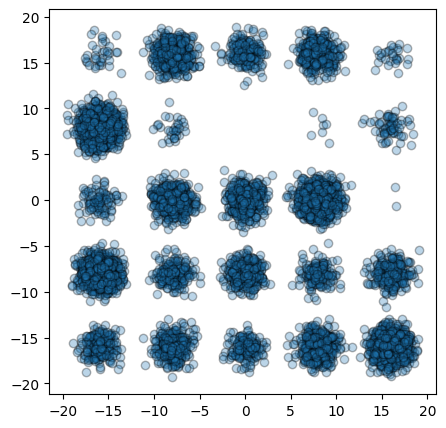

In [119]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.3)
plt.show()

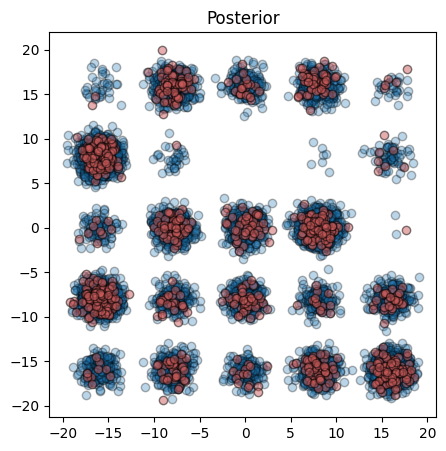

In [120]:
y = gmm.measure(1000)
x = gmm.posterior_sampling(y)
fig = plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.3)
plt.scatter(x[:,0], x[:,1], edgecolor="k", alpha=0.5, color="indianred")
plt.title("Posterior")
plt.show()

## Denoising diffusion model

### Forward process 

$$ x_{t+1} \mid x_t \sim \mathcal{N}(x_{t+1} ; \sqrt{1-\beta_t}x_t, \beta_t I)$$

### Backward process

$$ x_{t} \mid x_{t+1} \sim \mathcal{N}\left(x_{t} ; \frac{1}{\sqrt{\alpha_{t+1}}}\left(x_{t+1} + \beta_{t+1} s_{\theta}(x_{t+1}, t+1)\right), \beta_{t+1} I\right)$$

In [165]:
class ExactScoreMatching():
    def __init__(self, beta_start=1e-4, beta_end=0.02, num_steps=1000):
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        
        self.alphas = 1 - self.betas
        self.cum_alphas = torch.ones(num_steps+1)
        self.cum_alphas[1:] = torch.cumprod(self.alphas, dim=0)
        self.t = torch.linspace(0, 1, num_steps)
        self.gmm = GaussianMixtureModel()

    def log_prob(self, x, i) :                           
        weights, means, sigma = self.gmm.weights, torch.sqrt(self.cum_alphas[i])*self.gmm.centers, self.gmm.sigma
        y = x[:, None] - means[None, :] 
        log_p = torch.log(weights[None, :]) - torch.sum(y**2, axis=-1) / (2*sigma**2)
        return torch.logsumexp(log_p, dim=-1)

    def score(self, x, i):
        outputs = self.log_prob(x, i).sum()
        grad = torch.autograd.grad(outputs, x)
        return grad[0]

    def forward(self, x0):
        xi = torch.clone(x0)
        x_seq = [xi]
        for i, beta in enumerate(self.betas) :
            z = torch.randn(x0.shape)
            xi = torch.sqrt(1 - beta)*xi + torch.sqrt(beta)*z 
            x_seq.append(xi)
        return x_seq

    def backward(self, xT):
        x_i = torch.clone(xT)
        x_i.requires_grad_(True)
        x_seq = [x_i]
        times = torch.arange(self.num_steps-1, 0, step=-1)
        for i in tqdm(times):
            s_i = self.score(x_i, i)
            mu_i = 1/torch.sqrt(self.alphas[i]) * (x_i + self.betas[i] * s_i)
            x_i = mu_i + torch.sqrt(self.betas[i])*torch.randn(xT.shape)
            x_seq.append(x_i)
        return x_seq
    
    def DPS(self, y, gamma=1, scale = "adaptive") :
        N = len(y)
        x_i = torch.randn(N, 2)
        x_i.requires_grad_(True)
        x_seq = [x_i]
        times = torch.arange(self.num_steps-1, 0, step=-1)
        for i in tqdm(times):
            s_i = self.score(x_i, i)
    
            x_0_hat = 1/torch.sqrt(self.cum_alphas[i]) * (x_i + (1-self.cum_alphas[i])*s_i)

            zeta_i = -torch.sum((y - x_0_hat[:,:1])**2)/2 ## Here we should regularize with the noise level of y....but when it is noiseless
            guidance = torch.autograd.grad(zeta_i, x_i)[0]
            if scale == "adaptive" :   
                mu_i = 1/torch.sqrt(self.alphas[i]) * (x_i + self.betas[i] * (s_i + guidance))
            else :
                mu_i = 1/torch.sqrt(self.alphas[i]) * (x_i + self.betas[i] * s_i) + gamma*guidance
            x_i = mu_i + torch.sqrt(self.betas[i])*torch.randn(x_i.shape)
            x_i = x_i.detach().requires_grad_(True)
            x_seq.append(x_i)
        return x_seq
    
    def MCGdiff(self, y, mask_idx, obs_idx, n_particles=10):
        """
        Posterior sampling using MCGdiff algorithm
        """
        dx = len(mask_idx) + len(obs_idx)
        dy = len(obs_idx)
        z = torch.randn(n_particles, dx)
        K = (self.betas[1:] / (self.betas[1:] + 1 - self.alphas[:-1]))
        Xi_top = torch.zeros(n_particles, dy)
        Xi_top += K[-1]*torch.sqrt(self.cum_alphas[-1])*y + (1 - self.cum_alphas[-1])*K[-1]*z[:,obs_idx]
        Xi = torch.cat((Xi_top, z[:,mask_idx]), dim=-1)
        Xi.requires_grad_(True)
        times = torch.arange(self.num_steps-2, 0, step=-1)
        Xi_seq = [Xi]
        for i in tqdm(times):
            if i==self.num_steps-2:
                s_i = self.score(Xi, i+1)
                m = 1/torch.sqrt(self.alphas[i+1]) * (Xi + self.betas[i+1] * s_i)
                log_omegas = -torch.sum((self.cum_alphas[i+1]**.5*y[None,:] - m[:,obs_idx])**2/(2*(2 - self.cum_alphas[i+1])), axis=-1) - .5*torch.log(2 - self.cum_alphas[i+1])
            else :
                s_i = self.score(Xi, i+1)
                m = 1/torch.sqrt(self.alphas[i+1]) * (Xi + self.betas[i+1] * s_i)
                log_omegas = -torch.sum((self.cum_alphas[i]**.5*y[None,:] - m[:,obs_idx])**2/(2*(self.betas[i+1] + 1 - self.cum_alphas[i])), axis=-1) \
                - .5*torch.log(self.betas[i+1] + 1 - self.cum_alphas[i]) \
                + torch.sum((self.cum_alphas[i+1]**.5*y[None,:] - m[:,obs_idx])**2/(2*(1 - self.cum_alphas[i+1])), axis=-1)
                + .5*torch.log(1 - self.cum_alphas[i+1])
            z = torch.randn(n_particles, dx)
            prob = torch.exp(log_omegas - torch.logsumexp(log_omegas, axis=-1))

            #print(prob)
            I = torch.multinomial(prob, n_particles, replacement=True)
            Xi = Xi[I]
            Xi_top = torch.zeros(n_particles, dy)
            Xi_top += K[i]*self.cum_alphas[i]**.5*y + (1-K[i])*m[:, obs_idx] + (1-self.cum_alphas[i])**.5*K[i]**.5*z[:,obs_idx]
            Xi_bottom = m[:,mask_idx] + torch.sqrt(self.betas[i])*z[:,mask_idx]
            Xi = torch.cat((Xi_top, Xi_bottom), dim=-1)
            Xi_seq.append(Xi)

        return Xi_seq

In [166]:
y = torch.tensor([16])
torch.manual_seed(0)
N = 1000
esm = ExactScoreMatching(num_steps=N)

In [167]:
esm.cum_alphas

tensor([1.0000e+00, 9.9990e-01, 9.9978e-01,  ..., 4.2022e-05, 4.1182e-05,
        4.0358e-05])

In [168]:
esm.gmm.weights[23] = 0

In [169]:
X = esm.gmm.sample()
Xi = esm.MCGdiff(y, [1], [0], n_particles=2000)

100%|██████████| 998/998 [00:01<00:00, 666.74it/s]


In [170]:
Xi[-1].shape

torch.Size([2000, 2])

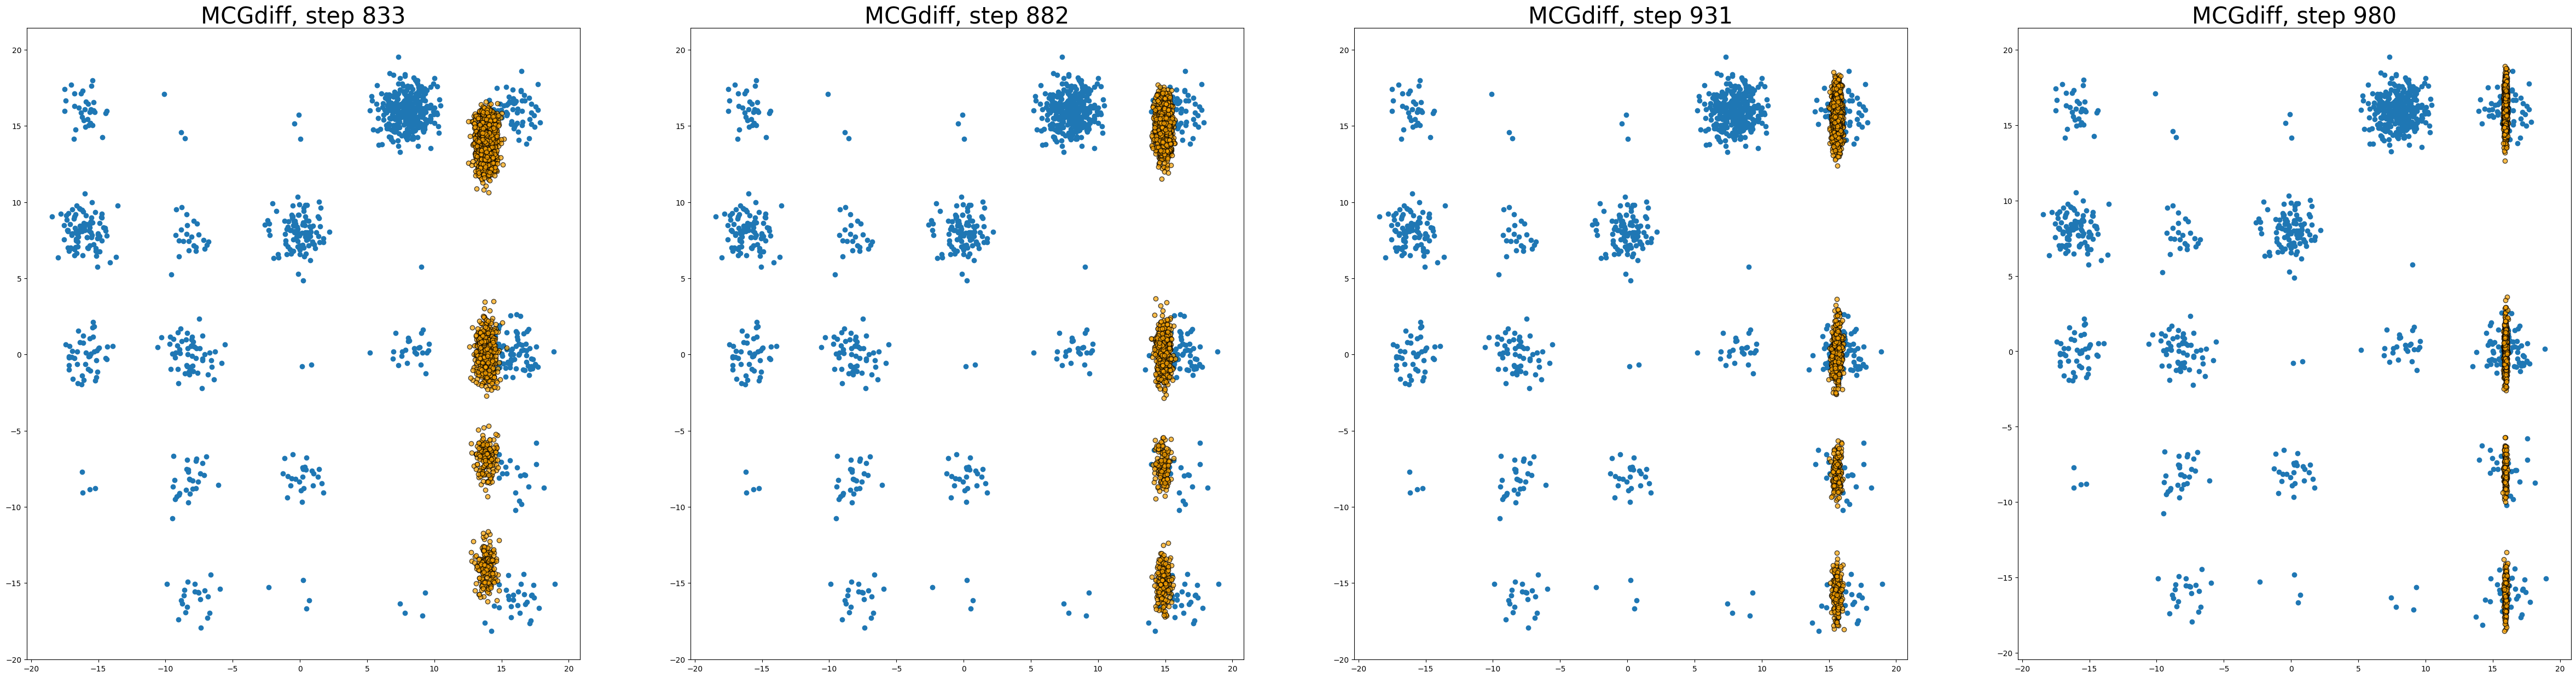

In [171]:
n_display = 4
idx = torch.arange(0, N, step=49)
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(60, 15))
for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(len(Xi[-1]))]
    ax[-i-1].scatter(X[:,0].detach(), X[:,1].detach())
    ax[-i-1].scatter(Xi[idx[-i-1]][:,0].detach(), Xi[idx[-i-1]][:,1].detach(), edgecolor="k", c="orange", alpha=0.7)
    ax[-i-1].set_title("MCGdiff, step {}".format(idx[-i-1]), fontsize=30)
plt.show()

In [172]:
torch.manual_seed(0)
N = 1000
esm = ExactScoreMatching(num_steps=N)

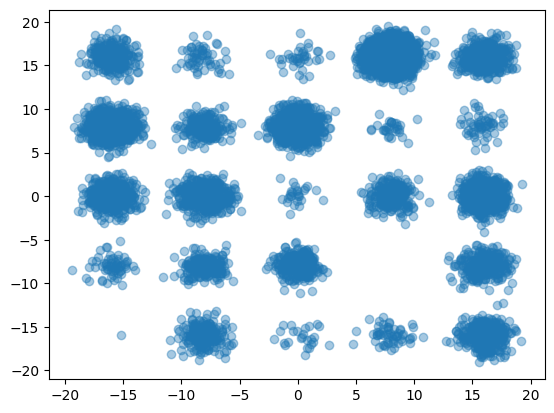

In [173]:
X = esm.gmm.sample(n_sample=n_sample)
plt.scatter(X[:,0], X[:,1], alpha=0.4)
#plt.scatter(xi[:,0].detach(), xi[:,1].detach(), alpha=0.4, c="indianred")
plt.show()

In [174]:
def log_prob(x, gmm) :                           
    weights, means, sigma = gmm.weights, gmm.centers, gmm.sigma
    y = x[:, None] - means[None, :] 
    log_p = torch.log(weights[None, :]) - torch.sum(y**2, axis=-1) / (2*sigma**2)
    return (torch.logsumexp(log_p, dim=-1))

def score(x, gmm):
    x.requires_grad_(True)
    outputs = log_prob(x, gmm).sum()
    grad = torch.autograd.grad(outputs, x)
    print(grad)
    return grad[0]

In [175]:
A = torch.linspace(20, -20, 200)
B = torch.linspace(-20, 20, 200)
T = torch.zeros((200, 200))
for i, y in enumerate(A) :
    for j, x in enumerate(B) :
        T[i, j] = log_prob(torch.Tensor([[x, y]]), esm.gmm)

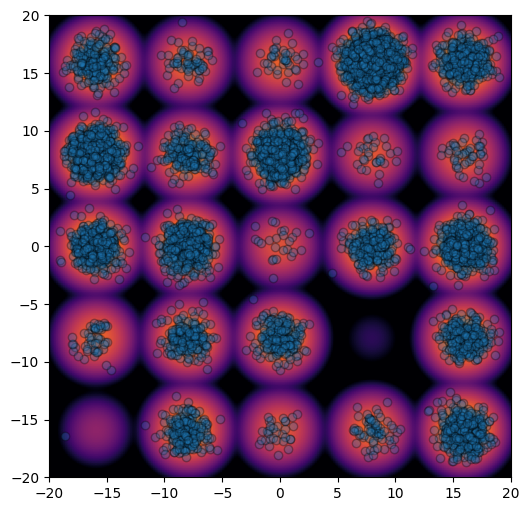

In [176]:
fig = plt.figure(figsize=(6, 6))
X = esm.gmm.sample(n_sample=n_sample)
plt.scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.3)

plt.imshow(T, cmap="inferno", vmin=-15, vmax=0, extent=[-20, 20, -20, 20])

In [177]:
X = esm.gmm.sample(n_sample=n_sample)
x_forward = esm.forward(X)

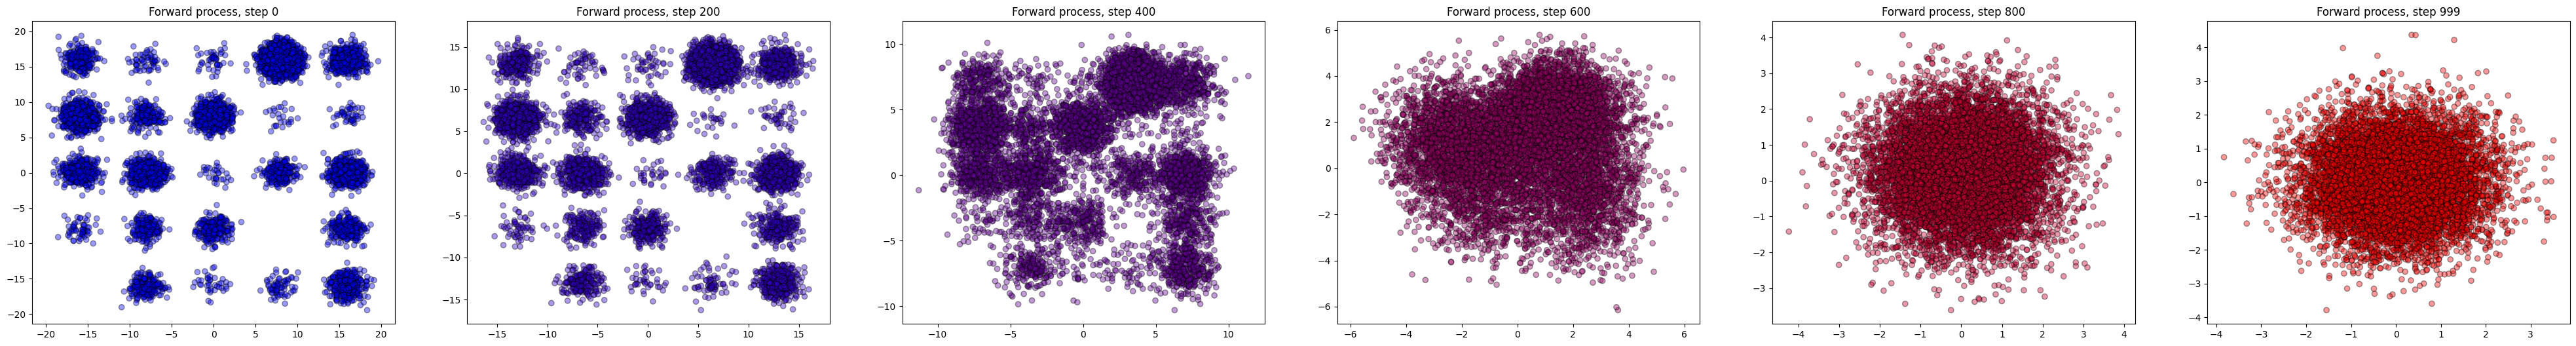

In [178]:
n_display = 6
idx = torch.arange(0, N, step=50)
idx = [0, 200, 400, 600, 800, 999]
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(50, 6))
for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(n_sample)]
    ax[i].scatter(x_forward[idx[i]][:,0], x_forward[idx[i]][:,1], edgecolor="k", c=c, alpha=0.4)
    ax[i].set_title("Forward process, step {}".format(idx[i]))
plt.show()

In [179]:
x_seq = esm.backward(x_forward[-1])

100%|██████████| 999/999 [00:01<00:00, 571.68it/s]


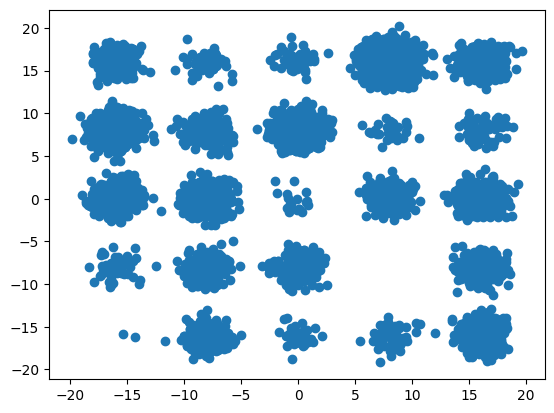

In [180]:
plt.scatter(x_seq[-1][:,0].detach(), x_seq[-1][:,1].detach())

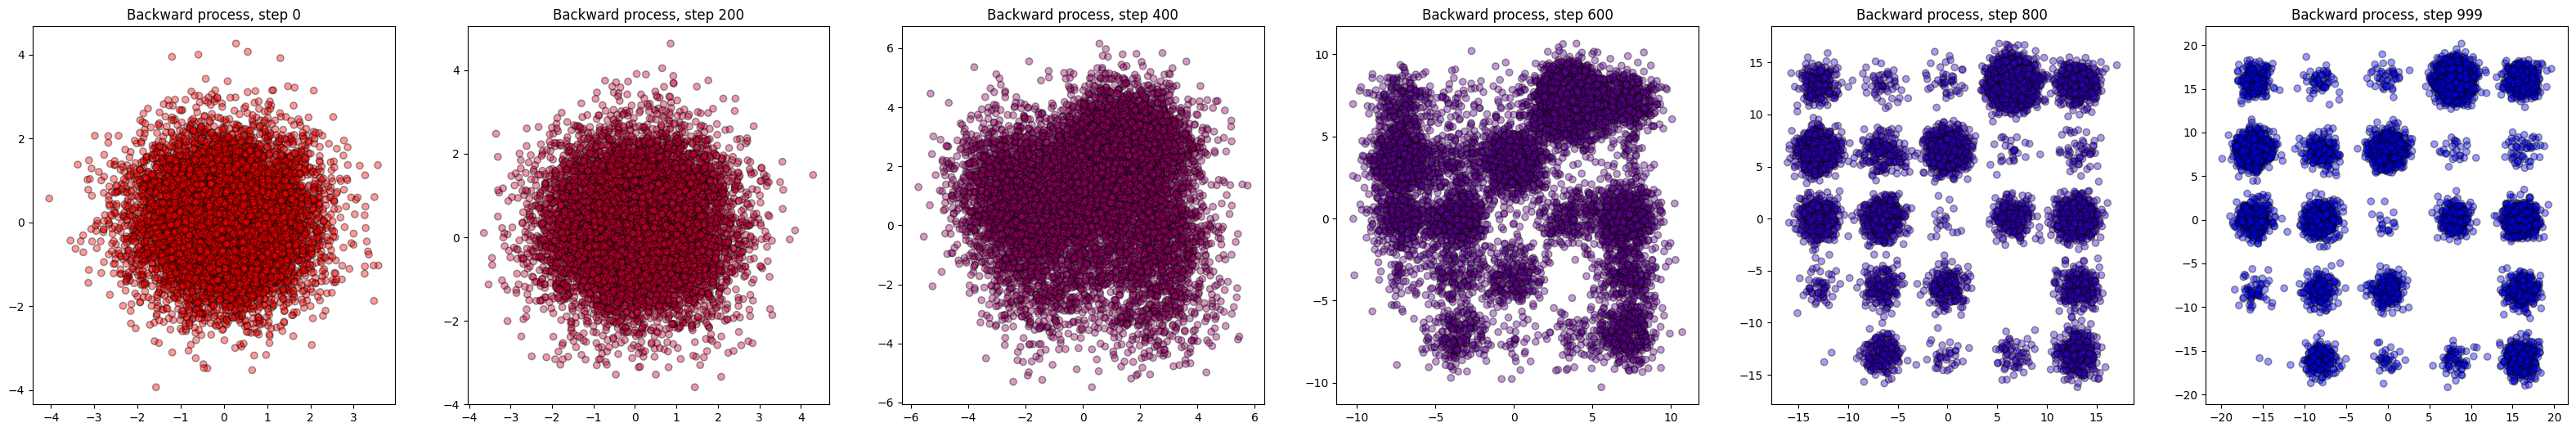

In [181]:
n_display = 6
idx = torch.arange(0, N, step=50)
idx = [0, 200, 400, 600, 800, 999]
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(40, 6))
for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(n_sample)]
    ax[-i-1].scatter(x_seq[idx[-i-1]][:,0].detach(), x_seq[idx[-i-1]][:,1].detach(), edgecolor="k", c=c, alpha=0.4)
    ax[-i-1].set_title("Backward process, step {}".format(idx[-i-1]))
plt.show()

In [182]:
N = 5000
y = 16*torch.ones(N, 1)

In [183]:
x_seq = esm.DPS(y, gamma=1e-1)

100%|██████████| 999/999 [00:01<00:00, 683.97it/s]


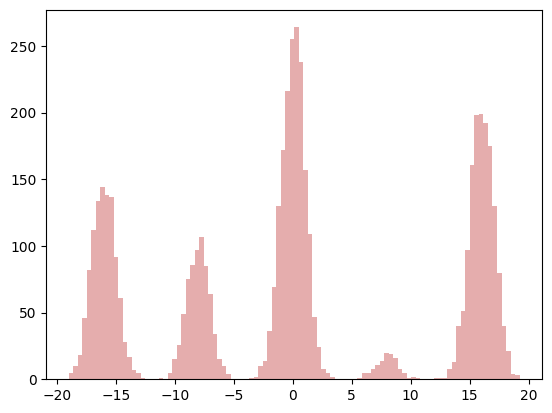

In [184]:
plt.hist(x_seq[-1][:,1].detach().numpy(), bins=100, alpha=0.5, color="indianred")
plt.show()

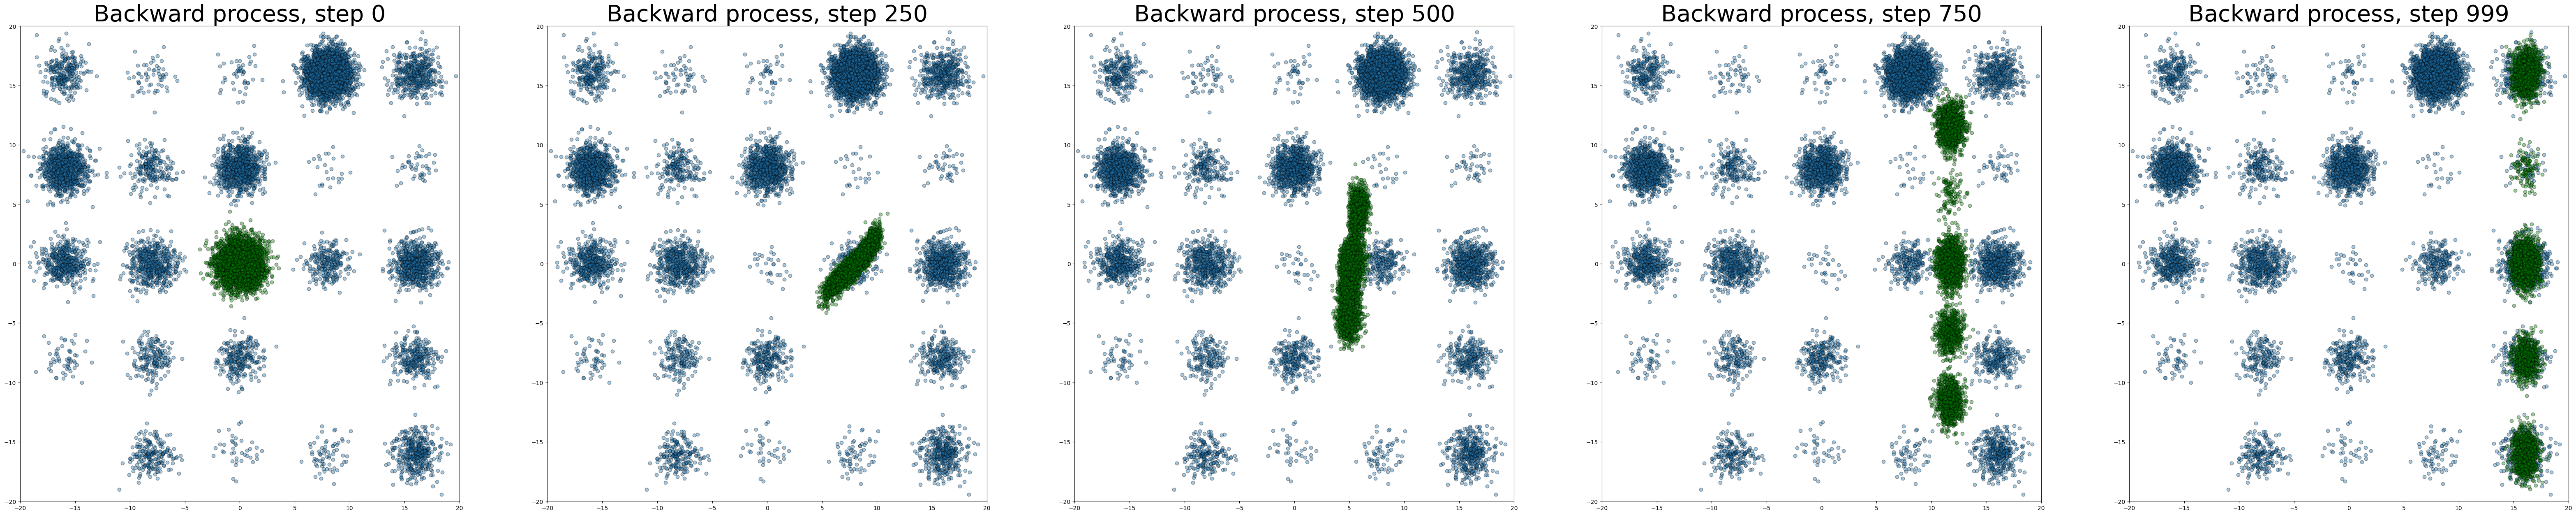

In [185]:
n_display = 5
Nt = 1000
idx = torch.arange(0, Nt+1, step=49)
idx=[0, 250, 500, 750, 999]
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(80, 15))
for i in range(n_display) :
    ax[-i-1].scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.4)
    ax[-i-1].scatter(x_seq[idx[-i-1]][:,0].detach(), x_seq[idx[-i-1]][:,1].detach(), edgecolor="k", c="green", alpha=0.4)
    ax[-i-1].set_title("Backward process, step {}".format(idx[-i-1]), fontsize=40)
    ax[-i-1].set_xlim([-20, 20])
    ax[-i-1].set_ylim([-20, 20])
plt.show()